In [1]:
import pandas as pd
import numpy as np
import psycopg2
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import DBSCAN
import datetime as dt
import matplotlib.pyplot as plt
import json
from gensim.models import Word2Vec

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 55)
pd.set_option('display.max_rows', 200)

plt.rcParams['figure.figsize'] = 12, 7

<ipython-input-1-eecf60652312>:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [6]:
%%time
hostname = 'production-backend-db-roreplica-01.c3trjnrdrwyu.eu-central-1.rds.amazonaws.com'
hostname = 'production-backend-db-roreplica-01.cy7iayle3ae8.eu-central-1.rds.amazonaws.com'
username = 'backend'
password = 'owrLKfs67LkfTyis71NfBgdsdf25'
database = 'backend'

with psycopg2.connect(host=hostname, user=username, password=password, dbname=database) as conn:
    with conn.cursor() as cursor:        
        query = """
select 
user_dates.user_id,
user_dates.created_at,
events.created_at as event_time,
events.action,
events.theta,
user_dates.label
from (
    select user_id,
    case
        when extract(day from max_created_at - med_created_at)::int >= 14 then med_created_at
        when max_created_at <= '2020-11-01'::date and extract(day from max_created_at - pd_created_at)::int <= extract(day from max_created_at - min_created_at)::int / 8 then max_created_at
    end as created_at,
    case
        when extract(day from max_created_at - med_created_at)::int >= 14 then 0
        when max_created_at <= '2020-11-01'::date and extract(day from max_created_at - pd_created_at)::int <= extract(day from max_created_at - min_created_at)::int / 8 then 1
    end as label
    from (
        select user_id,
        min(created_at) as min_created_at,
        percentile_disc(0.5) within group (order by created_at) as med_created_at,        
        percentile_disc(0.9) within group (order by created_at) as pd_created_at,
        max(created_at) as max_created_at
        from (select * from adjust_events where created_at between {0} and {1}) as ae
        join adjust_users as au on au.adid = ae.adid
        and activity_kind = 'session'
        group by user_id
    ) as foo
) as user_dates

left join (
    select user_id,
    u.created_at,
    'registration' as action,
    a.eyeball as theta
    from users as u
    left join accounts as a on a.user_id = u.id

    union all
    
    select user_id,
    d.created_at,
    'donation' as action,
    d.amount_cents as theta
    from donations as d
    join user_wallets as uw on uw.id = d.wallet_id
    
    union all

    select cv.user_id,
    cv.created_at,
    case
        when slot = 'instagram_story' and offer_cents is not null then 'paid_story_view'
        when slot = 'instagram_feed' and offer_cents is not null then 'paid_feed_view'
        when slot = 'instagram_story' and offer_cents is null then 'non_paid_story_view'
        when slot = 'instagram_feed' and offer_cents is null then 'non_paid_feed_view'
    end as action,
    offer_cents / nullif(eyeball, 0) * 1000 as theta
    from campaign_views as cv
    left join accounts as a on a.user_id = cv.user_id
    where cv.created_at between {0}::date - interval '{2} day' and {1}
    
    union all

    select au.user_id,
    created_at,
    case
        when activity_kind = 'session' then 'session'
        else event_name
    end as action,
    null as theta
    from adjust_events as ae
    join adjust_users as au on au.adid = ae.adid
    where ae.created_at between {0}::date - interval '{2} day' and {1}
    and event_name not in ('campaign_view', 'deal_post_inst', 'deal_post') 
    or activity_kind = 'session'
    
    union all
    
    select 
    a.user_id,
    p.created_at,
    case
        when variant_type = 1 then 'participation_feed'
        when variant_type = 2 then 'participation_story'
    end as action,
    e.amount_cents as theta
    from accounts as a
    join participations as p on p.account_id = a.id
    left join earnings as e on e.participation_id = p.id
    where a.provider_type = 4
    
    union all
    
    select user_id,
    created_at,
    'cpa_participation' as action,
    viewed_earning_cents as theta
    from cpa_participations
    
    union all
    
    select user_id,
    wt.created_at,
    'withdraw' as action,
    amount_cents as theta
    from withdraw_transactions as wt
    join withdraw_accounts as wa on wa.id = wt.withdraw_account_id
    
    union all
    
    select rr.parent_user_id as user_id,
    rr.created_at,
    'referral_made' as action,
    amount_cents as theta
    from referral_relations as rr
    left join referral_earnings as re 
    on re.referral_relation_id = rr.id and currency = 'RUB'
    
    union all
    
    select user_id,
    created_at,
    'magazine_view' as action,
    null as theta
    from magazine_users
    
) as events on events.user_id = user_dates.user_id
and events.created_at between user_dates.created_at - interval '{2} day' and user_dates.created_at
order by user_id, created_at
""".format("'2020-07-01'", "'2020-12-01'", 10)
        
        # where wt.status = 2 -- success
        
        query1 = """
        select user_id,
        case
            when extract(day from max_created_at - med_created_at)::int >= 14 then med_created_at
            when max_created_at <= '2020-11-01'::date and extract(day from max_created_at - pd_created_at)::int <= extract(day from max_created_at - min_created_at)::int / 8 then max_created_at
        end as created_at,
        case
            when extract(day from max_created_at - med_created_at)::int >= 14 then 0
            when max_created_at <= '2020-11-01'::date and extract(day from max_created_at - pd_created_at)::int <= extract(day from max_created_at - min_created_at)::int / 8 then 1
        end as label
        from (
            select user_id,
            min(created_at) as min_created_at,
            percentile_disc(0.5) within group (order by created_at) as med_created_at,        
            percentile_disc(0.9) within group (order by created_at) as pd_created_at,
            max(created_at) as max_created_at
            from (select * from adjust_events where created_at between '2020-06-01' and '2020-10-31') as ae
            join adjust_users as au on au.adid = ae.adid
            and activity_kind = 'session'
            group by user_id
        ) as foo
        """
        
        cursor.execute(query)
        results = cursor.fetchall()
        
#where created_at between {0}::date - interval '15 day' and {1}


CPU times: user 19.1 s, sys: 7.39 s, total: 26.5 s
Wall time: 1h 49min 37s


In [15]:
df = pd.DataFrame(results, columns=[cursor.description[i][0] for i in range(len(cursor.description))])
df = df.drop_duplicates()
df.sort_values(by=['user_id', 'event_time'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.dropna(axis=0, subset=['action'], inplace=True)
print(df.shape)
df.head()

(6188914, 6)


,user_id,created_at,event_time,action,theta,label
0,14,2020-09-21 20:57:06.025613,2020-09-14 18:56:54.933907,session,NaN,0.0
1,14,2020-09-21 20:57:06.025613,2020-09-14 18:56:59.276285,paid_feed_view,22000.0,0.0
2,14,2020-09-21 20:57:06.025613,2020-09-14 18:56:59.276285,paid_feed_view,19000.0,0.0
3,14,2020-09-21 20:57:06.025613,2020-09-14 18:56:59.276285,paid_feed_view,0.0,0.0
4,14,2020-09-21 20:57:06.025613,2020-09-14 18:57:00.782144,non_paid_feed_view,NaN,0.0


In [3]:
df.label.value_counts()

0.0    3319673
1.0    2869241
Name: label, dtype: int64

In [4]:
df[['user_id', 'created_at']].drop_duplicates().shape[0] == df[['user_id']].drop_duplicates().shape[0]

True

In [5]:
df.user_id.nunique()

108646

In [11]:
df.to_csv('actions.csv')

In [2]:
df = pd.read_csv('actions.csv', index_col=0)
print(df.shape)
df.head()

/home/konstantinlipkin/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(6188914, 6)


,user_id,created_at,event_time,action,theta,label
0,14,2020-09-21 20:57:06.025613,2020-09-14 18:56:54.933907,session,NaN,0.0
1,14,2020-09-21 20:57:06.025613,2020-09-14 18:56:59.276285,paid_feed_view,22000.0,0.0
2,14,2020-09-21 20:57:06.025613,2020-09-14 18:56:59.276285,paid_feed_view,19000.0,0.0
3,14,2020-09-21 20:57:06.025613,2020-09-14 18:56:59.276285,paid_feed_view,0.0,0.0
4,14,2020-09-21 20:57:06.025613,2020-09-14 18:57:00.782144,non_paid_feed_view,NaN,0.0


In [3]:
idxs_drop = []
user_list = []
for idx, row in tqdm(df[df.action == 'referral_made'].iterrows()):
    user_id = row.user_id
    if user_id not in user_list:
        user_list.append(user_id)
    else:
        idxs_drop.append(idx)

12564it [00:01, 9761.94it/s]


In [4]:
df = df[~df.index.isin(idxs_drop)]
del idxs_drop
df.reset_index(drop=True, inplace=True)
df.shape

(6180271, 6)

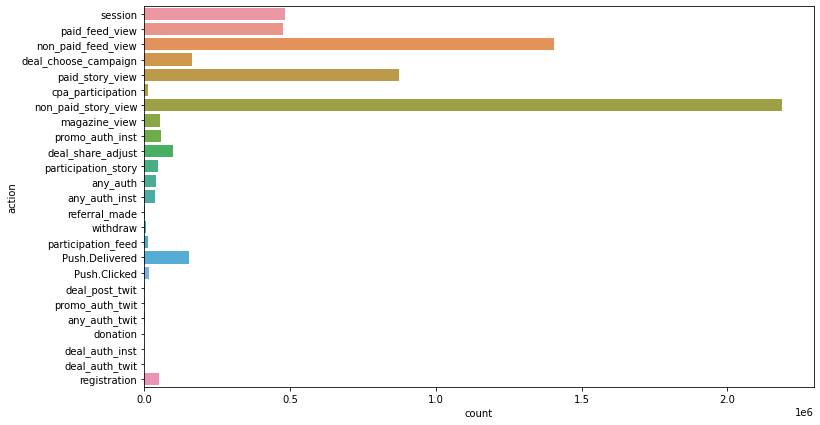

In [5]:
sns.countplot(data=df[~df.event_time.isna()], y='action');

In [6]:
df.action.value_counts()

non_paid_story_view     2187323
non_paid_feed_view      1406350
paid_story_view         873582 
session                 481693 
paid_feed_view          474850 
deal_choose_campaign    163052 
Push.Delivered          152248 
deal_share_adjust       99160  
promo_auth_inst         58657  
magazine_view           53550  
registration            49947  
participation_story     46740  
any_auth                39599  
any_auth_inst           38140  
Push.Clicked            16342  
participation_feed      12542  
cpa_participation       12038  
withdraw                4770   
referral_made           3921   
promo_auth_twit         2204   
deal_post_twit          1476   
any_auth_twit           1439   
deal_auth_inst          399    
donation                222    
deal_auth_twit          27     
Name: action, dtype: int64

In [7]:
insert_idxs = []
insert_idxs.append(0)
for row in tqdm(df.itertuples(), total=len(df)):
    idx = row.Index
    if idx == 0 or (row.user_id == df.at[idx-1, 'user_id']):
        continue
    else:
        insert_idxs.append(idx)

100%|██████████| 6180271/6180271 [01:26<00:00, 71376.17it/s]


In [8]:
df_dict = df.to_dict()

In [9]:
len(df_dict['user_id'])

6180271

In [10]:
len(set(insert_idxs))

108646

In [11]:
for idx in tqdm(insert_idxs):
    new_idx = idx - 0.5
    df_dict['user_id'][new_idx] = df_dict['user_id'][idx]
    df_dict['created_at'][new_idx] = df_dict['created_at'][idx]
    df_dict['event_time'][new_idx] = df_dict['event_time'][idx]
    df_dict['action'][new_idx] = 'start'
    df_dict['label'][new_idx] = df_dict['label'][idx]

100%|██████████| 108646/108646 [00:00<00:00, 309994.05it/s]


In [12]:
len(df_dict['user_id']) - len(df)

108646

In [13]:
len(insert_idxs), df.shape[0], len(insert_idxs) + df.shape[0]

(108646, 6180271, 6288917)

In [14]:
df = pd.DataFrame(df_dict)
df.shape

(6288917, 6)

In [15]:
df.sort_index(inplace=True)
df.reset_index(drop=True, inplace=True)

In [16]:
del df_dict

In [17]:
df_dict = df.to_dict()

In [18]:
user_idxs = {}
for k, v in df_dict['user_id'].items():
    user_idxs[v] = user_idxs.get(v, []) + [k]

In [19]:
len(user_idxs[14])

97

In [20]:
sequences = dict()

for user_id, idxs in tqdm(user_idxs.items()):
    actions = [df_dict['action'][idx] for idx in idxs]
    sequences[user_id] = actions

100%|██████████| 108646/108646 [00:01<00:00, 77041.89it/s]


In [21]:
len(sequences)

108646

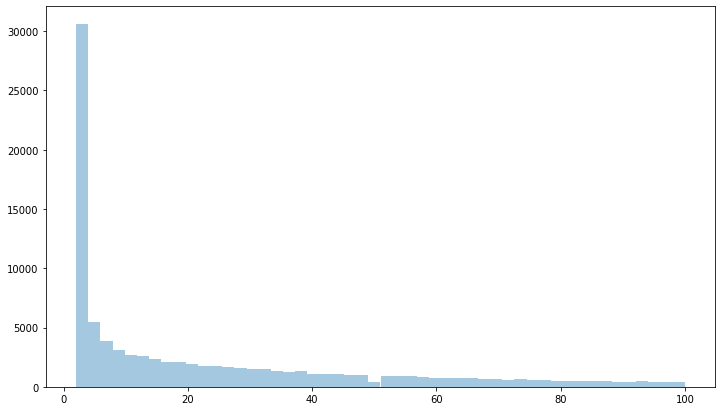

In [210]:
sns.distplot(pd.Series([len(v) for k, v in sequences.items() if len(v) <= 100]), kde=False);

In [22]:
w2v = Word2Vec(
    sentences=[v for k, v in sequences.items()], 
    size=100, window=15, min_count=3, workers=8
)

In [23]:
w2v.init_sims()
actions = [w2v.wv.index2word[idx] for idx in range(len(w2v.wv.vocab))]
matrix = pd.DataFrame(np.dot(w2v.wv.syn0norm, w2v.wv.syn0norm.T), columns=actions, index=actions)

<ipython-input-23-d1188abc6169>:3: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  matrix = pd.DataFrame(np.dot(w2v.wv.syn0norm, w2v.wv.syn0norm.T), columns=actions, index=actions)


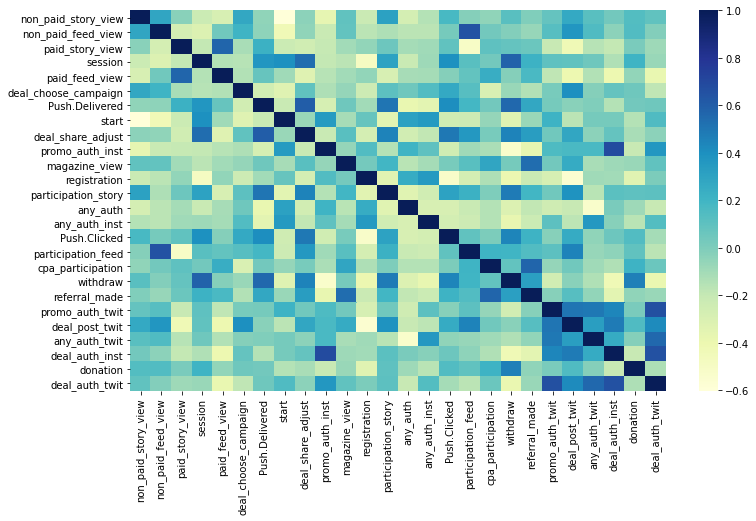

In [24]:
heatmap = sns.heatmap(matrix, cmap="YlGnBu");
#heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, position=(0,-0.1), va='center');

In [25]:
sequences_vec = {k: w2v[v] for k, v in sequences.items()}
sequences_vec[14].shape

<ipython-input-25-dbd56f0b6c73>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sequences_vec = {k: w2v[v] for k, v in sequences.items()}


(97, 100)

In [27]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

tau = 0.5
theta = 0.01
sigmoid(tau * 1 + theta * 10)
[(i, sigmoid(i)) for i in range(-5, 5)]

# formula = 0.5 * delta_t + 2.5 * 80%-quantile


[(-5, 0.0066928509242848554),
 (-4, 0.01798620996209156),
 (-3, 0.04742587317756678),
 (-2, 0.11920292202211755),
 (-1, 0.2689414213699951),
 (0, 0.5),
 (1, 0.7310585786300049),
 (2, 0.8807970779778823),
 (3, 0.9525741268224334),
 (4, 0.9820137900379085)]

In [28]:
#sns.distplot(df[df.action == 'withdraw'].theta)
thetas_map = {k: df[(df.action == k) & (~df.action.isna())].theta.quantile(0.8) for k in tqdm(df.action.unique())}
medians_map = {k: df[(df.action == k) & (~df.action.isna())].theta.median() for k in tqdm(df.action.unique())}
thetas_map = {k: v for k, v in thetas_map.items() if v > 0}
medians_map = {k: v for k, v in medians_map.items() if v > 0}

theta_const = 3
thetas_map = {k: theta_const / v for k, v in thetas_map.items()}

100%|██████████| 26/26 [00:13<00:00,  2.00it/s]


In [29]:
tau = 1

def calc_importance(dt, action, value):
    theta = thetas_map[action] if action in thetas_map else 0
    if pd.isna(value):
        value = medians_map[action] if action in medians_map else 0
    inp = tau * dt + theta * value - 2

    return sigmoid(inp)

for user_id, idxs in tqdm(user_idxs.items()):
    actions_vec = sequences_vec[user_id]
    actions = sequences[user_id]
    thetas = [df_dict['theta'][idx] for idx in idxs]
    deltas = [df_dict['event_time'][idx] for idx in idxs]
    if max(deltas) == min(deltas):
        coefs = calc_importance(1, actions[0], thetas[0])
        coefs = [coefs] * len(actions)
        assert len(deltas) in (1, 2)
    else:
        deltas = [dt.datetime.timestamp(dt.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f')) for d in deltas]
        deltas = [(d - min(deltas)) / (max(deltas) - min(deltas)) for d in deltas]
        coefs = [calc_importance(dt, action, value) for dt, action, value in zip(deltas,actions, thetas)]
    
    result_vec = np.mean([a_vec * coef for a_vec, coef in zip(actions_vec, coefs)], axis=0)
    sequences_vec[user_id] = result_vec
    #break

100%|██████████| 108646/108646 [03:18<00:00, 548.70it/s]


In [32]:
list(zip(coefs, thetas, actions))

[(0.11920292202211755, nan, 'start'),
 (0.11920292202211755, nan, 'session'),
 (0.11921551450309952, nan, 'deal_choose_campaign'),
 (0.11923510175884311, nan, 'deal_share_adjust'),
 (0.1433803424050858, nan, 'session'),
 (0.1434168453037857, nan, 'deal_choose_campaign'),
 (0.14343958978505125, nan, 'deal_share_adjust'),
 (0.17576987674160097, nan, 'session'),
 (0.18023800114336277, nan, 'session'),
 (0.18026688544123282, nan, 'deal_choose_campaign'),
 (0.1802880473296321, nan, 'deal_choose_campaign'),
 (0.1803053966362157, nan, 'deal_choose_campaign'),
 (0.1803253879294616, nan, 'deal_choose_campaign'),
 (0.1803471686626349, nan, 'deal_share_adjust'),
 (0.19147904825528234, nan, 'session'),
 (0.19453964375565788, nan, 'session'),
 (0.1945427764331504, nan, 'deal_choose_campaign'),
 (0.19454396511339878, nan, 'deal_choose_campaign'),
 (0.19458276783355302, nan, 'deal_share_adjust'),
 (0.2689414213699951, nan, 'session')]

In [65]:
sequences_vec = {k: np.mean(v, axis=0) for k, v in sequences_vec.items()}

In [33]:
for k in tqdm(sequences_vec):
    for val in sequences_vec[k]:
        #print(sequences_vec[k].shape)
        if pd.isna(val):
            print('here')
            break

100%|██████████| 108646/108646 [00:04<00:00, 24953.02it/s]


In [21]:
import pandas as pd
sc = pd.read_csv('/home/konstantinlipkin/Downloads/scores1.csv', index_col=0)
sc[sc.ix == 250]
sc.shape

(78133, 2)

In [22]:
from tqdm import tqdm
deltas = []
for idx, row in tqdm(sc.iterrows()):
    d = sc[sc.ix == row.ix].score
    if len(d) > 1:
        deltas.append(abs(d.iloc[0] - d.iloc[1]))

78133it [01:21, 960.22it/s] 


<AxesSubplot:>

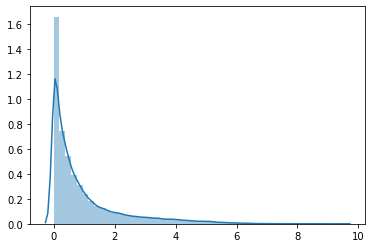

In [25]:
import seaborn as sns
deltas = pd.Series(deltas)
sns.distplot([d for d in deltas if d <= 10])

In [31]:
deltas[deltas <= 0.2].shape[0] / 1

25204.0

In [10]:
sc[sc.score <= -3.8].shape

(18008, 2)

In [ ]:
import torch

encoder = torch.load('model_checkpoints/encoder_epoch_1_train_loss_0.6454_test_loss_0.5629_train_acc_0.7922_test_acc_0.8160')
eh = torch.load('model_checkpoints/eh_epoch_1_train_loss_0.6454_test_loss_0.5629_train_acc_0.7922_test_acc_0.8160')
sequences_vec = encoder(inputs, hidden, tau, eh)

In [22]:
%%time
hostname = 'production-backend-db-roreplica-01.c3trjnrdrwyu.eu-central-1.rds.amazonaws.com'
hostname = 'production-backend-db-roreplica-01.cy7iayle3ae8.eu-central-1.rds.amazonaws.com'
username = 'backend'
password = 'owrLKfs67LkfTyis71NfBgdsdf25'
database = 'backend'

with psycopg2.connect(host=hostname, user=username, password=password, dbname=database) as conn:
    with conn.cursor() as cursor:        
        query = """
select distinct
a.user_id,
case
    when date_of_birth is not null then extract(year from age(u.date_of_birth))
    else u.age_predicted
end as age,
case
    when u.gender is not null then u.gender
    else u.gender_predicted
end as gender,
a.eyeball,
a.followers_count,
a.is_verified,
a.is_private,
a.story_eyeball,
case
    when platform = 1 then 'ios'
    when platform = 2 then 'android'
end as platform,
a.status,
at.premium_score,
at.content_similarity,
at.tags,
a.r
from (select *, row_number() over (partition by user_id order by id desc) as r 
      from accounts 
      where provider_type = 4
) as a
left join (select *, row_number() over (partition by user_id order by id desc) as r from devices) as d 
on d.user_id = a.user_id and d.r = 1 and a.r = 1
left join (select *, row_number() over (partition by provider_id order by id desc) as r from account_taggings) as at
on at.provider_id = a.provider_id and at.r = 1
join users as u on u.id = a.user_id

""".format(tuple(df.user_id.to_list()))
        
        query1 = """
        select counts, count(user_id)
        from (
        select user_id, count(id) as counts
        from accounts as a
        group by user_id
        ) as f
        group by counts
        order by counts
        """
                
        cursor.execute(query)
        results = cursor.fetchall()

CPU times: user 5.93 s, sys: 666 ms, total: 6.59 s
Wall time: 8min 34s


In [23]:
df_stats = pd.DataFrame(results, columns=[cursor.description[i][0] for i in range(len(cursor.description))])
df_stats = df_stats[df_stats.user_id.isin(df.user_id)]
df_stats = df_stats[df_stats.r == 1]
df_stats.index = df_stats.user_id
del df_stats['r'], df_stats['user_id']
print(df_stats.shape)
df_stats.head()

(107585, 12)


,age,gender,eyeball,followers_count,is_verified,is_private,story_eyeball,platform,status,premium_score,content_similarity,tags
user_id,,,,,,,,,,,,
14,31.0,male,1000.0,155.0,False,True,1000.0,android,0,0E-15,None,[]
20,39.0,male,1034.0,238.0,False,False,1034.0,ios,0,0.536545114813147,0.611712841308125,"[travel, arts]"
22,25.0,female,176.0,2225.0,False,False,224.0,ios,0,0.860522155551442,0.619411781204765,"[food, beauty, travel]"
59,29.0,male,106.0,756.0,False,False,75.0,ios,0,0.424095479690449,0.419030606624412,[pets]
147,28.0,male,56.0,305.0,False,False,0.0,ios,1,0.378219560714085,0.276196092367172,[travel]


In [24]:
df.user_id.nunique()

108646

In [25]:
df_stats.loc[14].to_numpy()

array([31.0, 'male', 1000.0, 155.0, False, True, 1000.0, 'android', 0,
       Decimal('0E-15'), None, list([])], dtype=object)

In [66]:
sequences_vec = {k: np.concatenate([v, df_stats.loc[k].to_numpy() if k in df_stats.index else np.array([np.nan] * len(df_stats.columns))]) for k, v in sequences_vec.items()}

In [34]:
labels = df[['label']]
labels.index = df.user_id
sequences_vec = {k: np.concatenate([v, labels.at[k, 'label'][:1]]) for k, v in sequences_vec.items()}

In [37]:
data = list(sequences_vec.values())
data = pd.DataFrame(data, columns=list(map(str, range(100))) + \
                    #df_stats.columns.to_list() +\
                    ['label'])
data['label'] = data.label.astype(int)
for col in data.columns:
    if col not in ['label',
                  # *df_stats.columns.to_list()
                  ]:
        data[col] = data[col].astype(np.float32)

In [39]:
tag_list = list(set([tag for tags in data.tags if isinstance(tags, list) for tag in tags]))

for idx, row in tqdm(data.iterrows(), total=len(data)):
    tags = row.tags
    for tag in tag_list:
        if isinstance(tags, list) and tag in tags:
            data.at[idx, tag] = 1
        else:
            data.at[idx, tag] = 0

AttributeError: 'DataFrame' object has no attribute 'tags'

In [38]:
data.shape

(108646, 101)

In [39]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,...,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,label
0,-0.391112,-0.023497,-0.465609,-0.891918,-0.320021,-0.047509,1.666616,0.508683,1.852587,-0.587340,-0.221623,0.491659,-2.410171,-1.205991,0.760348,0.822169,0.095654,0.562864,0.367324,-0.528421,1.315150,0.398310,-0.351253,0.028962,-0.600804,-0.405109,-1.528620,...,-0.612191,0.194027,0.932809,-0.151180,-0.920437,0.658286,0.371839,0.260429,-0.732671,1.064488,-0.889954,-0.377993,1.127184,0.148503,-0.264713,0.699730,-0.435238,-0.524855,-1.367226,0.711732,0.293495,-0.076114,-0.671457,0.950281,-0.235068,-0.605069,0
1,-0.611526,-0.103905,-1.350241,-0.549417,0.309749,0.336800,1.644398,0.939749,0.989372,-0.682746,-0.175515,-0.569016,-0.669934,-0.791788,1.164147,0.859006,-1.018112,0.475622,0.161013,-0.266676,1.346804,0.309578,-0.538970,0.059610,-0.770346,0.851722,-0.847321,...,-0.015200,-0.030206,1.257127,-0.150951,-0.569182,-0.334485,-0.693895,0.260442,0.354326,1.111906,-0.451841,-0.211530,-0.035391,0.335656,-1.022827,0.665177,0.369128,-0.244392,-0.653423,0.092696,0.209831,0.170478,-0.386429,1.083254,1.092103,-0.546065,0
2,0.232946,0.167616,0.418367,-0.263916,0.039391,0.485588,0.202279,-0.882195,-0.182517,-0.162343,0.012433,0.256106,0.465214,0.117811,-0.154834,0.286803,0.147292,-0.117197,-0.194692,0.170020,-0.140796,-0.447037,-0.207517,0.002724,0.056798,-0.155225,-0.204507,...,0.150879,0.014194,-0.056525,0.080770,0.180448,-0.155493,-0.133816,0.017465,0.262467,-0.138917,0.182677,0.117023,-0.206847,-0.264438,0.025015,-0.217806,-0.036368,0.266117,0.318718,0.176474,-0.168473,-0.079168,-0.157819,-0.444702,0.095347,0.255459,0
3,-0.549093,-0.080783,-0.795164,-0.629383,-0.011310,0.069979,1.358431,0.768159,1.275133,-0.555475,-0.115299,0.004085,-1.503119,-0.799796,0.803472,0.670615,-0.424275,0.439839,0.219771,-0.340775,1.170569,0.350574,-0.432093,0.012028,-0.669299,0.167827,-1.053260,...,-0.320943,0.071502,0.976940,-0.136959,-0.693375,0.180109,-0.088340,0.221852,-0.224743,1.016289,-0.637089,-0.290679,0.518440,0.278134,-0.541450,0.656286,-0.031764,-0.397421,-0.896058,0.336946,0.225162,0.080042,-0.527464,1.094042,0.306237,-0.574666,0
4,0.137319,0.130648,0.121703,-0.199706,0.028892,0.335033,0.151163,-0.528463,-0.021807,-0.054325,-0.003500,0.102656,0.400082,0.070946,-0.032092,0.156245,0.040753,-0.066653,-0.149669,0.139609,-0.067257,-0.320963,-0.020314,0.015571,0.066347,-0.057467,-0.023384,...,0.070896,-0.015329,-0.094622,0.132394,0.075702,-0.082091,-0.037054,-0.001519,0.086717,-0.105220,0.091713,-0.023012,-0.092844,-0.204815,0.038214,-0.087384,-0.034226,0.227620,0.207186,0.058373,-0.126971,-0.015793,-0.124108,-0.242137,0.034510,0.243767,1


In [40]:
data.label.value_counts()

1    68370
0    40276
Name: label, dtype: int64

In [100]:
data.isna().sum(axis=0)[data.isna().sum(axis=0) != 0][::-1][:]

tags                  2181 
content_similarity    32738
premium_score         2819 
status                1061 
platform              3162 
story_eyeball         1422 
is_private            1061 
is_verified           8115 
followers_count       1884 
eyeball               1420 
gender                26835
age                   25934
dtype: int64

In [101]:
dict_merge = lambda a,b: a.update(b) or a

data['age'] = pd.qcut(data.age, q=5).astype(str).apply(lambda x: x.replace('(', '').replace(']', '')).fillna('nan')
data['gender'] = data.gender.fillna('nan')
data['eyeball'] = data.eyeball.fillna(data.eyeball.mean())
data['followers_count'] = data.followers_count.fillna(data.eyeball.mean())
data['is_verified'] = data.is_verified.fillna(2).map({False: '0', True: '1', 2: '2'})
data['is_private'] = data.is_private.fillna(2).map({False: '0', True: '1', 2: '2'})
data['story_eyeball'] = data.story_eyeball.fillna(data.story_eyeball.mean())
data['platform'] = data.platform.fillna('nan')
data['status'] = data.status.fillna(2).map(dict_merge({i: str(i) for i in range(int(data.status.max()))}, {2: '-1'}))
data['premium_score'] = data.premium_score.fillna(data.premium_score.mean())
data['content_similarity'] = data.content_similarity.fillna(data.content_similarity.mean())

if 'tags' in data.columns:
    del data['tags']

In [41]:
cd ml-utils/helpers/binary_classification/

/home/konstantinlipkin/Anaconda_files/ml-utils/helpers/binary_classification


In [42]:
from dataset import BinaryClassDataset
from model_cv import Classification

np.random.seed(0)
dataset = BinaryClassDataset(
    data[-10000:]
    #data.sample(10000)
)

In [113]:
cat_cols = ['age', 'gender', 'is_verified', 'is_private', 'platform', 'status']
dataset.one_hot_encoding(cross_prod_dim=2, columns=cat_cols)

100%|██████████| 10/10 [00:00<00:00, 31.29it/s]


In [43]:
dataset.X.shape

(10000, 100)

In [44]:
dataset.y.value_counts()

1    5801
0    4199
Name: label, dtype: int64

In [60]:
%%time
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

grid_rf = {
    'n_estimators': [200, 250, 300, 400],
    'max_depth': [8, 10, 15, 20],
    'max_features': ['auto', 0.7, 0.8, 0.9]
}

grid_rf = {
    'n_estimators': [250, 300],
    'max_depth': [10],
    'max_features': [0.9]
}

grid_svm = {
    'C': [0.5, 1.0, 2]
}

grid_lr = {
    'C': [0.5, 1.0, 2]
}

#svm = (grid_svm, SVC, probability=True)

clf = Classification(lib='sklearn', clf=GradientBoostingClassifier)
clf.cross_validation(dataset, randomized=True, param_grid=grid_rf, scoring=roc_auc_score, cv=3, verbose=1)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/home/konstantinlipkin/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.1min finished


CPU times: user 2min 25s, sys: 875 ms, total: 2min 25s
Wall time: 5min 33s


In [118]:
for col in dataset.X.columns:
    if col != 'label':
        dataset.X[col] = dataset.X[col].astype(float)

In [45]:
%%time
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score

grid_xgb = {
      'n_estimators': [200, 250, 300, 350],
      'learning_rate': [0.02, 0.05, 0.07],
      'subsample': [0.8, 0.9, 1.0],
      'max_depth': [3, 5, 7, 9],
      'colsample_bytree': [0.5, 0.75, 1.0],
      'min_child_weight': [1, 2, 3],
#      'scale_pos_weight': [0.4, 0.5, 0.6]
}

clf = Classification(
    lib='xgboost', 
    clf=XGBClassifier, 
    objective = 'binary:logistic',
    n_jobs=-1
)

clf.cross_validation(
    dataset, 
    randomized=True, 
    param_grid=grid_xgb, 
    scoring=roc_auc_score, 
    cv=3, 
    verbose=1 
)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.1min finished


CPU times: user 33.6 s, sys: 739 ms, total: 34.4 s
Wall time: 2min 35s


In [46]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score

metrics = {
    'conf': confusion_matrix,
    'accuracy': accuracy_score,
    'f1': f1_score
}

thresh_list = [0.2, 0.3, 0.4, 0.5, 0.6]
#thresh_list = [0.4, 0.5, 0.6, 0.7, 0.8]

result = clf.get_result(metrics=metrics, thresh_list=thresh_list)
result

{'analyze_data': {'best_estimator': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=0.75, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.02, max_delta_step=0, max_depth=9,
                min_child_weight=2, missing=nan, monotone_constraints='()',
                n_estimators=300, n_jobs=-1, num_parallel_tree=1, random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
                tree_method='exact', validate_parameters=1, verbosity=None),
  'best_score': 0.6968971656683571,
  'best_params_': {'subsample': 0.9,
   'n_estimators': 300,
   'min_child_weight': 2,
   'max_depth': 9,
   'learning_rate': 0.02,
   'colsample_bytree': 0.75},
  'class_balance': 0.58,
  'conf_0.2': [[192, 648], [42, 1118]],
  'conf_0.3': [[247, 593], [69, 1091]],
  'conf_0.4': [[292, 548], [99, 1061]],
  'conf_0.5': [[358, 482]

In [74]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score

metrics = {
    'conf': confusion_matrix,
    'accuracy': accuracy_score,
    'f1': f1_score
}

thresh_list = [0.2, 0.3, 0.4, 0.5, 0.6]
#thresh_list = [0.4, 0.5, 0.6, 0.7, 0.8]

result = clf.get_result(metrics=metrics, thresh_list=thresh_list)
result

{'analyze_data': {'best_estimator': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.05, max_delta_step=0, max_depth=3,
                min_child_weight=3, missing=nan, monotone_constraints='()',
                n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
                tree_method='exact', validate_parameters=1, verbosity=None),
  'best_score': 0.7187081706952391,
  'best_params_': {'subsample': 0.9,
   'n_estimators': 200,
   'min_child_weight': 3,
   'max_depth': 3,
   'learning_rate': 0.05,
   'colsample_bytree': 1.0},
  'class_balance': 0.58,
  'conf_0.2': [[162, 678], [27, 1133]],
  'conf_0.3': [[235, 605], [50, 1110]],
  'conf_0.4': [[314, 526], [94, 1066]],
  'conf_0.5': [[391, 449], 